In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cv2
import numpy as np

## Get first frame of a video

In [10]:
def apply_mask(frame, mask):
  """
    ``apply_mask`` applies a the binary mask `mask` to the given `frame` of a video.

    :param frame: frame of a video in `cv2.COLOR_BGR2GRAY` format
    :param mask: binary mask with same size as `frame`
    :return: returns the frame image with the mask applied
    """ 
  return cv2.bitwise_and(frame, frame, mask=mask)

In [ ]:
filename = "M20251108_192006_MasLaRoca_S.avi"

cap = cv2.VideoCapture(filename)
ret, first_frame = cap.read()
first_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
cv2.imwrite("M20251108_192006_MasLaRoca_S_first_frame.png", first_frame_gray)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
my_mask = np.zeros((height, width), dtype=np.uint8)
mask_height = height - 30
cv2.rectangle(my_mask, (0, 0), (width, mask_height), 255, thickness=-1)

masked_first_frame = apply_mask(first_frame_gray, my_mask)
cv2.imwrite("M20251108_192006_MasLaRoca_S_first_frame_masked.png", masked_first_frame)

True

## To know how many new samples there are in december 2025

In [3]:
df = pd.read_csv("epochs_model_v1.6_256.csv", sep=";")
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'epochs_model_v1.6_256.csv'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   epoch     100 non-null    int64  
 1   schedule  100 non-null    float64
 2   loss      100 non-null    float64
 3   accuracy  100 non-null    float64
 4   time      100 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 4.0 KB


In [10]:
df_temp = df[df["year"] == 2025]
df_temp = df_temp[df_temp["month"] == 12]
df_temp = df_temp[df_temp["day"] > 6]
df_temp.shape

(6262, 19)

## To get results from SSL training

In [4]:
epoch36_max_acc = float(df["accuracy"].iloc[:36].max())
epoch36_time = float(df["time"].iloc[:36].sum())
print("Max accuracy at epoch 36:", epoch36_max_acc)
print("Training time until epoch 36:", epoch36_time/3600)


NameError: name 'df' is not defined

In [9]:
max_acc = float(df["accuracy"].max())
time = float(df["time"].sum())
stop_epoch = df["epoch"].iloc[-1]
print("Max accuracy:", max_acc)
print("Training time:", time/3600)
print("Stop-epoch:", stop_epoch)

Max accuracy: 0.695164798393843
Training time: 5.995822073618571
Stop-epoch: 100


## Get the augmentations matrix

In [2]:
import pandas as pd

augmentation_matrix = [[None] * 4 for _ in range(4)]
order = [(0,0), (1,1), (2,2), (3,3), (0,1), (1,2), (2,3), (0,2), (1,3), (0,3)]

for i in range(10):
    df = pd.read_csv(f"epochs_model_v2.6.{i+1}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    time = float(df["time"].sum())

    augmentation_matrix[(order[i][0])][(order[i][1])] = max_acc

for i in range(4):
    for j in range(4):
        augmentation_matrix[j][i] = augmentation_matrix[i][j]

for row in augmentation_matrix:
    print(row)

# Additional augmentations from v1.6.11 to v1.6.14
additional_augmentations = []
for i in range(11, 15):
    df = pd.read_csv(f"epochs_model_v2.6.{i}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    additional_augmentations.append(max_acc)

print("\nAdditional augmentations (v1.6.11 to v1.6.14):")
print(additional_augmentations)

# All augmentations combinations (v1.6.15 and v1.6.16)
all_augmentations = []
for i in range(15, 16):
    df = pd.read_csv(f"epochs_model_v2.6.{i}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    all_augmentations.append(max_acc)

print("\nAll augmentations (v1.6.15 and v1.6.16):")
print(all_augmentations)

[0.8362054542412581, 0.8270035134682951, 0.8373766103396353, 0.8408900786347666]
[0.8270035134682951, 0.8335285260163962, 0.8382131504099046, 0.8387150744520663]
[0.8373766103396353, 0.8382131504099046, 0.8318554458758575, 0.8343650660866655]
[0.8408900786347666, 0.8387150744520663, 0.8343650660866655, 0.8408900786347666]

Additional augmentations (v1.6.11 to v1.6.14):
[0.8392169984942279, 0.8407227706207128, 0.8360381462272043, 0.8300150577212648]

All augmentations (v1.6.15 and v1.6.16):
[0.8444035469298979]


Text(108.22222222222221, 0.5, '')

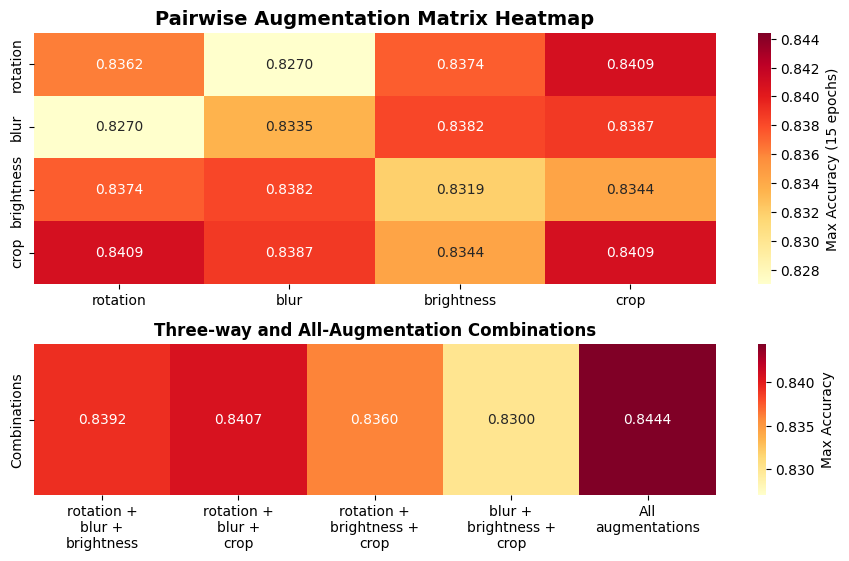

In [6]:
augmentations = ["rotation", "blur", "brightness", "crop"]

# Calculate global min and max for consistent color scaling
all_values = []
for row in augmentation_matrix:
    all_values.extend([val for val in row if val is not None])
all_values.extend(additional_augmentations)
all_values.extend(all_augmentations)
vmin = min(all_values)
vmax = max(all_values)

# Create figure with custom grid layout
fig = plt.figure(figsize=(11, 6))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 0.6], width_ratios=[0.8, 0.4], hspace=0.3, wspace=0.05)

# First heatmap: 4x4 augmentation matrix (spans full width on top)
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(augmentation_matrix, 
            annot=True, 
            fmt='.4f', 
            cmap='YlOrRd',
            xticklabels=augmentations,
            yticklabels=augmentations,
            cbar_kws={'label': 'Max Accuracy (15 epochs)'},
            vmin=vmin,
            vmax=vmax,
            ax=ax1)
ax1.set_title('Pairwise Augmentation Matrix Heatmap', fontsize=14, fontweight='bold')

# Second heatmap: 1x5 for additional augmentations (v1.6.11 to v1.6.15)
ax2 = fig.add_subplot(gs[1, :])   # bottom row spans full width

# Build a single row with 5 cells:
# 4 three-way combinations + 1 all-augmentations value
combined_matrix = [additional_augmentations + [all_augmentations[0]]]

xticklabels = [
    'rotation +\nblur +\nbrightness',
    'rotation +\nblur +\ncrop',
    'rotation +\nbrightness +\ncrop',
    'blur +\nbrightness +\ncrop',
    'All\naugmentations'
]

sns.heatmap(
    combined_matrix,
    annot=True,
    fmt='.4f',
    cmap='YlOrRd',
    xticklabels=xticklabels,
    yticklabels=['Combinations'],
    cbar_kws={'label': 'Max Accuracy'},
    vmin=vmin,
    vmax=vmax,
    ax=ax2
)

ax2.set_title('Three-way and All-Augmentation Combinations', fontsize=12, fontweight='bold')
ax2.set_ylabel('')


# Third heatmap: 1x1 for all augmentations
# ax3 = fig.add_subplot(gs[1, 1])

# # Ensure it's a 1x1 matrix
# all_matrix = [[all_augmentations[0]]]

# sns.heatmap(all_matrix,
#             annot=True,
#             fmt='.4f',
#             cmap='YlOrRd',
#             xticklabels=['All\naugmentations'],
#             yticklabels=['All'],
#             cbar_kws={'label': 'Max Accuracy'},
#             vmin=vmin,
#             vmax=vmax,
#             ax=ax3)

# ax3.set_title('All Augmentations Combinations', fontsize=12, fontweight='bold')
# ax3.set_ylabel('')

# Test set

In [2]:
test_set = pd.read_csv("unknown_labeled.csv", sep=";")

In [3]:
test_set.describe()

,filename,class
count,363,363
unique,363,14
top,M20251215_011509_MasLaRoca_W,car_lights
freq,1,86


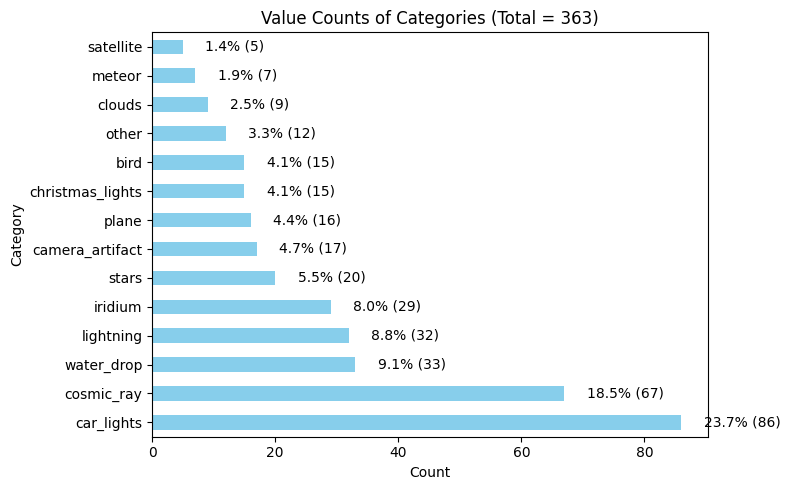

In [16]:
counts = test_set["class"].value_counts()
total = counts.sum()
percentages = counts / total * 100

plt.figure(figsize=(8, 5))

# Horizontal bar plot
counts.plot(kind='barh', color='skyblue')

# Add percentage labels to each bar
for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(count + total*0.01, i, f"{pct:.1f}% ({count})", va='center')

plt.xlabel('Count')
plt.ylabel('Category')
plt.title(f'Value Counts of Categories (Total = {total})')

plt.tight_layout()
plt.show()
